## Inverse Problem

This notebook is a simple example of how to solve an inverse problem using at3d. It assumes that we have run the 'SimulateRadiances' notebook and saved the result.

In [1]:
#imports
import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
import warnings
np.random.seed(1)


### Load Measurements

Here we load the synthetic measurements and also all of the inputs to the solver. We will use several of these inputs to perform 'inverse crimes' whereby we fix some aspects of the problem perfectly as in the forward simulation. When using real world measurements no such short cuts are necessary.

* First, we have to look at the measurements and select a region of interest and define our `rte_grid`. 
* Then we have to model the sensor sub-pixel geometry.
* We need to analyze whether the grid and sensor geometry are consistent. The SpaceCarver is useful for this. If not then we may need to change resolution of `rte_grid` to match the resolution of the measurements etc.
* We need to decide how to represent the surface, which is currently fixed.
* We need to decide how to represent the atmosphere.
    * What scattering species are we modelling? What are their optical models? 
    * Which quantities will be unknowns and which are fixed?
    * What will be the abstract state that we will reconstruct? For this we need to set the mapping between the abstract state and the RTE solver.
* Now that we are organized we need to initialize our state vector of unknowns. The method for this initialization may itself be quite involved as starting nearer the answer is better. This typically goes hand in hand with the selection of any fixed variables.
* Lastly we perform the optimization.

In this tutorial we will reconstruct only the `extinction` and we will use forward quantities from the ground truth synthetic measurements for simplicity.

### Load

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiancesSmallRico.nc')

In [3]:
# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 0*2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, bcflag=3)
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [4]:

# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)#at3d.uncertainties.TandemStereoCamera('L2', camera_to_camera_calibration_uncertainty=0.0,
              #                                      absolute_calibration_uncertainty=0.0)#at3d.uncertainties.RadiometricUncertainty('L2',1e-5, 1e-3)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}

mie_mono_tables = OrderedDict()
for wavelength in [.66]:
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )

optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    at3d.size_distribution.gamma,
    density_normalization='geometric_extinction',
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

In [5]:
# set the generator for the unknown scatterer using ground truth optical properties
# and unknown extinction.
# GridToOpticalProperties holds the fixed optical properties and forms a full set of optical properties
# when it is called with extinction as the argument.

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')

true_geo_extinct = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)


%matplotlib inline
def plot(optimizer):
    py.figure()
    fig, axs = py.subplots(1, 2)
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            true_geo_extinct.ravel(),'x')
    axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[1].plot([0,30],[0,30])
    axs[1].axvline(x = np.nanmean(solvers[0.66].medium['cloud'].reff.data.ravel()), color = 'r', linestyle='--')
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)


In [6]:
solvers_reconstruct = at3d.containers.SolversDict()

# We are using the ground_truth rte_grid.
grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, optical_properties
)
def get_loss(reff_diff):
    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.385E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.425E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.651  0.437E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.880  0.275E+00    32095    40.32  0.158   [Radiance 0.660 micron]
     5  -2.177  0.159E+00    32758    44.39  0.173   [Radiance 0.660 micron]
     6  -2.234  0.933E-01    34714    55.00  0.215   [Radiance 0.660 micron]
     7  -2.361  0.681E-01    37274    67.53  0.264   [Radiance 0.660 micron]
     8  -2.423  0.520E-01    40638    81.64  0.319   [Radiance 0.660 micron]
     9  -2.528  0.431E-01    44384    95.05  0.371   [Radiance 0.660 micron]
    10  -2.593  0.358E-01    49065   108.85  0.425   [Radiance 0.660 micron]
    11  -2.680  0.308E-01    53642   119.95  0.469   [Radiance 0.660 micron]
    12  -2.942  0.300E-01    54740   122.38  0.478   [Radiance 0.660 micron]
  

<Figure size 640x480 with 0 Axes>

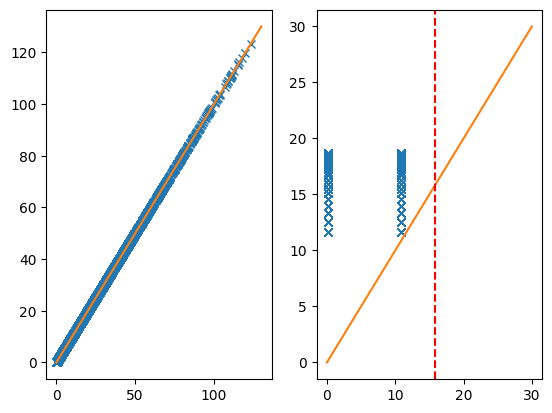

202.3426390100024
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.383E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.423E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.652  0.434E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.882  0.274E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.183  0.158E+00    32746    44.32  0.173   [Radiance 0.660 micron]
     6  -2.234  0.925E-01    34713    54.99  0.215   [Radiance 0.660 micron]
     7  -2.365  0.677E-01    37199    67.21  0.263   [Radiance 0.660 micron]
     8  -2.425  0.517E-01    40571    81.37  0.318   [Radiance 0.660 micron]
     9  -2.531  0.429E-01    44210    94.48  0.369   [Radiance 0.660 micron]
    10  -2.599  0.356E-01    48908   108.43  0.424   [Radiance 0.660 micron]
    11  -2.676  0.306E-01    53592   119.87  0.468   [Radiance 0.660 micron]
    12  -2.961  0.300E-01    54374   121.59  0.475   [Radianc

<Figure size 640x480 with 0 Axes>

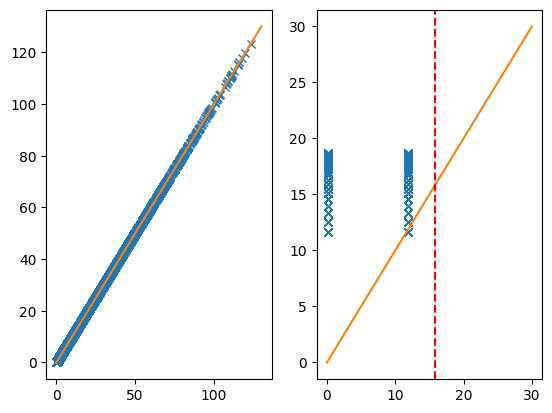

126.0585894575617
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.381E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.420E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.653  0.432E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.884  0.272E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.184  0.157E+00    32748    44.34  0.173   [Radiance 0.660 micron]
     6  -2.238  0.921E-01    34669    54.78  0.214   [Radiance 0.660 micron]
     7  -2.366  0.673E-01    37200    67.23  0.263   [Radiance 0.660 micron]
     8  -2.428  0.515E-01    40506    81.13  0.317   [Radiance 0.660 micron]
     9  -2.531  0.426E-01    44122    94.18  0.368   [Radiance 0.660 micron]
    10  -2.601  0.355E-01    48706   107.85  0.421   [Radiance 0.660 micron]
    11  -2.679  0.305E-01    53386   119.42  0.466   [Radiance 0.660 micron]
    12  -2.965  0.300E-01    54037   120.82  0.472   [Radianc

<Figure size 640x480 with 0 Axes>

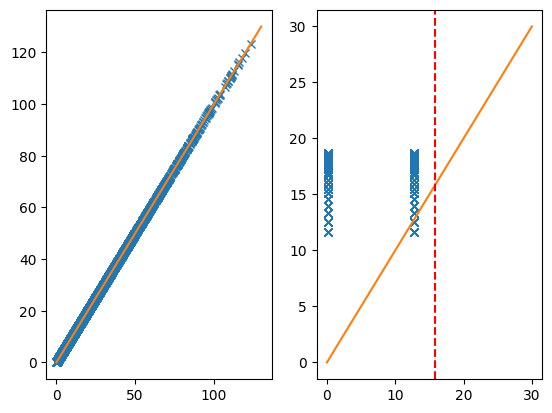

75.14472150690271
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.379E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.333  0.418E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.654  0.429E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.885  0.271E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.188  0.156E+00    32748    44.34  0.173   [Radiance 0.660 micron]
     6  -2.240  0.916E-01    34659    54.72  0.214   [Radiance 0.660 micron]
     7  -2.368  0.670E-01    37184    67.16  0.262   [Radiance 0.660 micron]
     8  -2.427  0.512E-01    40426    80.82  0.316   [Radiance 0.660 micron]
     9  -2.535  0.426E-01    43968    93.70  0.366   [Radiance 0.660 micron]
    10  -2.599  0.354E-01    48608   107.60  0.420   [Radiance 0.660 micron]
    11  -2.692  0.305E-01    53095   118.78  0.464   [Radiance 0.660 micron]
    12  -2.955  0.300E-01    53785   120.29  0.470   [Radianc

<Figure size 640x480 with 0 Axes>

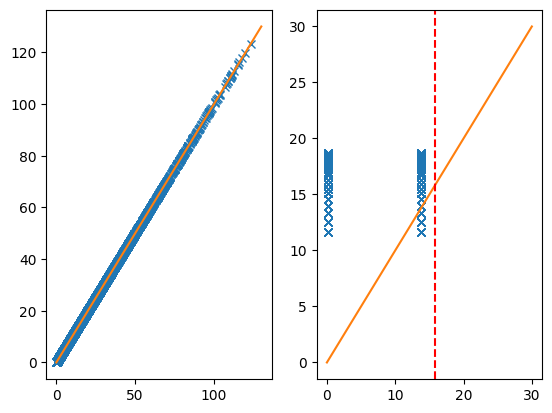

42.12988719157385
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.378E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.417E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.428E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.886  0.270E+00    32086    40.26  0.157   [Radiance 0.660 micron]
     5  -2.190  0.156E+00    32746    44.32  0.173   [Radiance 0.660 micron]
     6  -2.242  0.911E-01    34642    54.65  0.213   [Radiance 0.660 micron]
     7  -2.367  0.666E-01    37182    67.15  0.262   [Radiance 0.660 micron]
     8  -2.431  0.511E-01    40362    80.60  0.315   [Radiance 0.660 micron]
     9  -2.532  0.424E-01    43901    93.50  0.365   [Radiance 0.660 micron]
    10  -2.602  0.354E-01    48431   107.15  0.419   [Radiance 0.660 micron]
    11  -2.690  0.304E-01    52941   118.42  0.463   [Radiance 0.660 micron]
    12  -2.960  0.300E-01    53558   119.79  0.468   [Radianc

<Figure size 640x480 with 0 Axes>

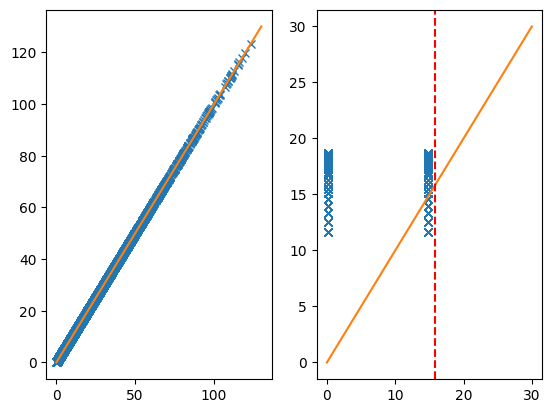

21.363628513430754
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.377E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.415E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.426E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.887  0.268E+00    32087    40.27  0.157   [Radiance 0.660 micron]
     5  -2.192  0.155E+00    32746    44.32  0.173   [Radiance 0.660 micron]
     6  -2.245  0.909E-01    34615    54.53  0.213   [Radiance 0.660 micron]
     7  -2.367  0.664E-01    37167    67.07  0.262   [Radiance 0.660 micron]
     8  -2.434  0.510E-01    40305    80.36  0.314   [Radiance 0.660 micron]
     9  -2.532  0.422E-01    43862    93.39  0.365   [Radiance 0.660 micron]
    10  -2.602  0.353E-01    48297   106.81  0.417   [Radiance 0.660 micron]
    11  -2.690  0.304E-01    52775   118.06  0.461   [Radiance 0.660 micron]
    12  -2.985  0.300E-01    53302   119.24  0.466   [Radian

<Figure size 640x480 with 0 Axes>

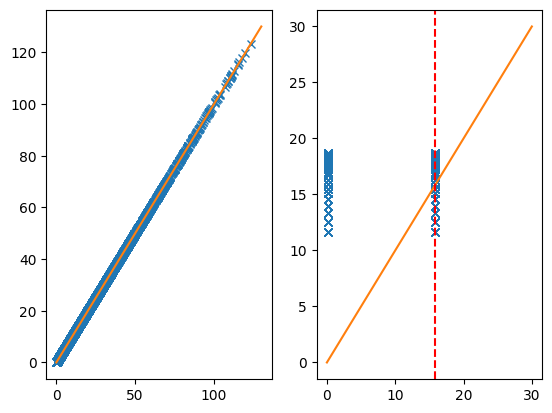

10.140824218413456
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.375E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.414E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.655  0.424E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.888  0.268E+00    32085    40.26  0.157   [Radiance 0.660 micron]
     5  -2.194  0.155E+00    32733    44.26  0.173   [Radiance 0.660 micron]
     6  -2.245  0.905E-01    34605    54.47  0.213   [Radiance 0.660 micron]
     7  -2.371  0.662E-01    37150    67.00  0.262   [Radiance 0.660 micron]
     8  -2.430  0.508E-01    40311    80.39  0.314   [Radiance 0.660 micron]
     9  -2.540  0.423E-01    43714    92.89  0.363   [Radiance 0.660 micron]
    10  -2.599  0.351E-01    48321   106.89  0.418   [Radiance 0.660 micron]
    11  -2.692  0.304E-01    52607   117.69  0.460   [Radiance 0.660 micron]
    12  -2.988  0.300E-01    53136   118.85  0.464   [Radian

<Figure size 640x480 with 0 Axes>

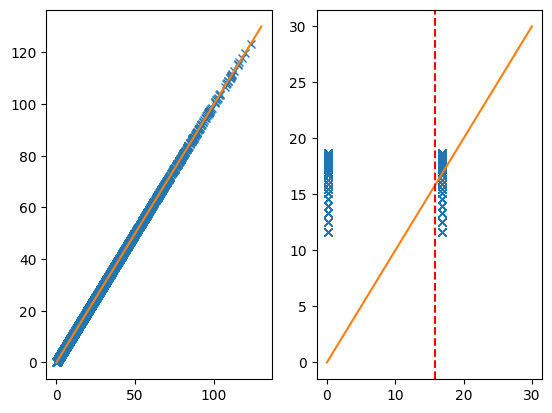

5.678431455228688
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.728  0.374E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.413E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.656  0.423E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.889  0.267E+00    32081    40.23  0.157   [Radiance 0.660 micron]
     5  -2.196  0.154E+00    32730    44.24  0.173   [Radiance 0.660 micron]
     6  -2.246  0.902E-01    34605    54.48  0.213   [Radiance 0.660 micron]
     7  -2.372  0.660E-01    37132    66.91  0.261   [Radiance 0.660 micron]
     8  -2.430  0.507E-01    40278    80.25  0.313   [Radiance 0.660 micron]
     9  -2.542  0.422E-01    43640    92.67  0.362   [Radiance 0.660 micron]
    10  -2.597  0.350E-01    48250   106.69  0.417   [Radiance 0.660 micron]
    11  -2.696  0.304E-01    52426   117.28  0.458   [Radiance 0.660 micron]
    12  -2.985  0.300E-01    52983   118.52  0.463   [Radianc

<Figure size 640x480 with 0 Axes>

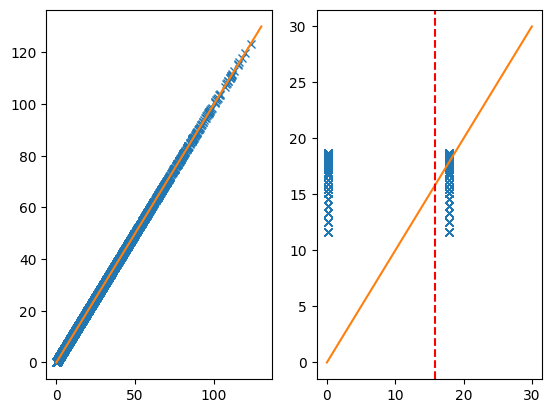

6.2990962506815915
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.373E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.412E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.656  0.422E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.890  0.267E+00    32081    40.23  0.157   [Radiance 0.660 micron]
     5  -2.198  0.154E+00    32730    44.24  0.173   [Radiance 0.660 micron]
     6  -2.247  0.899E-01    34591    54.41  0.213   [Radiance 0.660 micron]
     7  -2.373  0.659E-01    37120    66.84  0.261   [Radiance 0.660 micron]
     8  -2.431  0.505E-01    40243    80.12  0.313   [Radiance 0.660 micron]
     9  -2.542  0.421E-01    43619    92.60  0.362   [Radiance 0.660 micron]
    10  -2.599  0.350E-01    48169   106.48  0.416   [Radiance 0.660 micron]
    11  -2.697  0.303E-01    52345   117.07  0.457   [Radiance 0.660 micron]
    12  -2.994  0.300E-01    52816   118.12  0.461   [Radian

<Figure size 640x480 with 0 Axes>

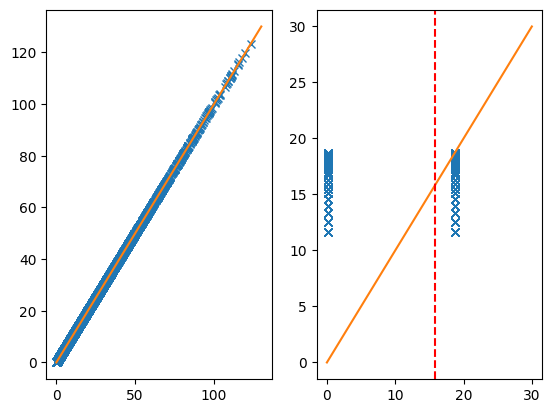

10.528360985934112
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.727  0.372E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     2  -1.332  0.411E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     3  -1.656  0.421E+00    31968    39.47  0.154   [Radiance 0.660 micron]
     4  -1.890  0.266E+00    32081    40.23  0.157   [Radiance 0.660 micron]
     5  -2.199  0.154E+00    32728    44.23  0.173   [Radiance 0.660 micron]
     6  -2.248  0.897E-01    34582    54.36  0.212   [Radiance 0.660 micron]
     7  -2.374  0.657E-01    37106    66.78  0.261   [Radiance 0.660 micron]
     8  -2.432  0.505E-01    40214    80.02  0.313   [Radiance 0.660 micron]
     9  -2.542  0.421E-01    43580    92.47  0.361   [Radiance 0.660 micron]
    10  -2.600  0.349E-01    48103   106.29  0.415   [Radiance 0.660 micron]
    11  -2.698  0.303E-01    52227   116.77  0.456   [Radiance 0.660 micron]
    12  -2.997  0.300E-01    52691   117.85  0.460   [Radian

<Figure size 640x480 with 0 Axes>

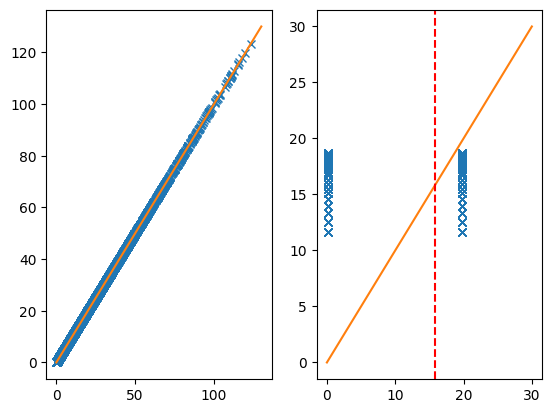

17.569777338163213


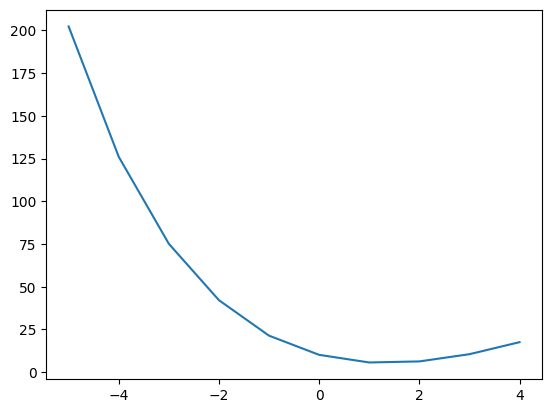

In [ ]:
solvers_reconstruct = at3d.containers.SolversDict()
def get_loss_uniform(reff_diff):
    # We are using the ground_truth rte_grid.
    grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
        rte_grid, optical_property_generator, optical_properties
    )

    # UnknownScatterers is a container for all of the unknown variables.
    # Each unknown_scatterer also records the transforms from the abstract state vector
    # to the gridded data in physical coordinates.
    unknown_scatterers = at3d.containers.UnknownScatterers(
        at3d.medium.UnknownScatterer(grid_to_optical_properties,
        density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)),
        reff=(None, at3d.transforms.StateToGridUniform(mask=carved_volume.mask.data)))
    )
    # now we form state_gen which updates the solvers with an input_state.

    state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                            unknown_scatterers, surfaces,
                                            numerical_parameters, sources, background_optical_scatterers,
                                            num_stokes)
    # get bounds automatically.
    min_bounds, max_bounds = state_gen.transform_bounds()
    # transform initial physical state to abstract state. 
    initial_gridded_extinction = 3.0*solvers[0.66].medium['cloud'].density.data/(2.0*997.0* solvers[0.66].medium['cloud'].reff.data*1e-6)
    initial_1d_extinction = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_extinction)
    initial_gridded_reff = solvers[0.66].medium['cloud'].reff.data*0 + solvers[0.66].medium['cloud'].reff.data.ravel().mean() + reff_diff
    initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
    x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_extinction),
                state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)))
    objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
        sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
        state_gen.project_gradient_to_state,
            parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
        gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
        uncertainty_kwargs={'add_noise': False},
        min_bounds=min_bounds, max_bounds=max_bounds)
    # solvers_reconstruct[0.66].medium['cloud'].reff.data = solvers[0.66].medium['cloud'].reff.data + reff_diff
    return objective_function(x0)[0]
losses = []
for i in range(-5, 5):
    losses.append(get_loss_uniform(i))
    plot(None)
    print(losses[i+5])
py.plot(range(-5, 5),losses)